# TESS example: The decreasing orbital period of WASP-4b

[Bouma et al. (2019)](http://adsabs.harvard.edu/abs/2019AJ....157..217B). discovered that the TESS-observed transits of WASP-4b occur 81.6 ± 11.7 seconds earliear than what predicted by the ephemeris based on the previous observations. This would correspond to the orbital period decreasing -12.6 milliseconds per year. Here we reproduce the analysis using PyTransit.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [23]:
import pandas as pd
import seaborn as sb

from pathlib import Path
from uncertainties import ufloat
from scipy.stats import norm

from pytransit.lpf.tesslpf import TESSLPF, fold, downsample_time
from pytransit.param import NormalPrior as NP

In [3]:
dfile = Path('data/tess2018234235059-s0002-0000000402026209-0121-s_lc.fits')
npop         = 150
nlegendre    = 1
mcmc_repeats = 4

## Calculate the prior ephemeris

First, we calculate the prior ephemeris using the transit centres from previous research. The table is taken from [Bouma et al. (2019)](http://adsabs.harvard.edu/abs/2019AJ....157..217B), who did the hard work of going through the literature and weeding the reliable estimates from the unreliable ones.

In [4]:
centers = pd.read_csv('data/wasp_4b_transit_times.csv', sep='\t', header=0)
c, ccov = polyfit(centers.epoch, centers.time, deg=1, w=1/centers.error, cov=True)

zero_epoch = ufloat(c[1], sqrt(ccov[1,1]))
period     = ufloat(c[0], sqrt(ccov[0,0]))

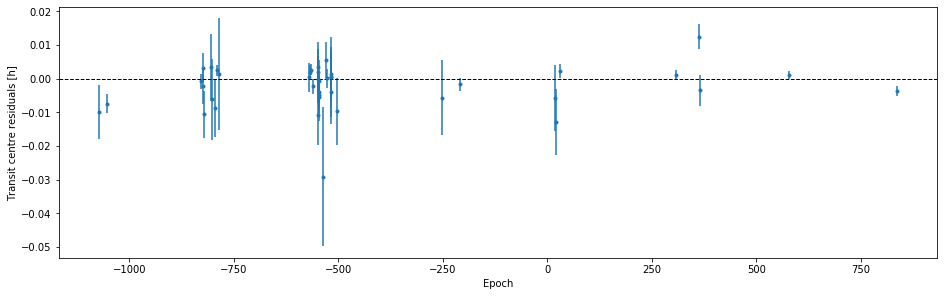

In [5]:
residuals = centers.time - poly1d(c)(centers.epoch)
fig, ax = subplots(figsize=(13,4), constrained_layout=True)
ax.errorbar(centers.epoch, 24*residuals, 24*centers.error, fmt='.')
ax.axhline(0, c='k', lw=1, ls='--')
setp(ax, xlabel='Epoch', ylabel='Transit centre residuals [h]');

## Create the Log Posterior function

### Initialise the log posterior function and set the transit centre and period priors

We first set a wide normal prior on the transit centre that corresponds to the centre time of the first expected transit in the TESS data, but with uncertainty multiplied by 20 to make sure our prior doesn't dominate the posterior. We also set a wide normal prior on the period centred around the original period estimate, but very wide.

[Bouma et al. (2019)](http://adsabs.harvard.edu/abs/2019AJ....157..217B) fitted each transit separately with the flux baseline modelled with a linear slope. We also use a linear slope for each transit (by setting `nlegendre = 1`. I also did check whether adding more complexity would make any difference to the analysis, but it didn't really change the outcome.), but model the transits jointly. This is slightly slower than their approach (because of the larger number of free parameters), but generally more robust. Fitting each transit separately takes some seconds per transit, while the joint analysis takes some minutes.

In [6]:
lpf = TESSLPF('WASP-4b', dfile, zero_epoch.n, period.n, nsamples=2, bldur=0.25, nlegendre=nlegendre)

tn = int(round((lpf.times[0].mean() - lpf.zero_epoch) / period.n))
tc = zero_epoch + tn*period - lpf.bjdrefi

lpf.set_prior(0, NP(tc.n, 20*tc.s))           # Wide normal prior on the transit center
lpf.set_prior(1, NP(period.n, 1e6*period.s))  # Wide normal prior on the orbital period

### Print the model parameters

In [7]:
lpf.print_parameters(columns=3)

  0 |G| tc         [-inf ..  inf]	  1 |G| pr         [0.00 ..  inf]	  2 |G| rho        [0.00 ..  inf]
  3 |G| b          [0.00 .. 1.00]	  4 |P| k2         [0.00 .. 0.56]	  5 |P| q1_0       [0.00 .. 1.00]
  6 |P| q2_0       [0.00 .. 1.00]	  7 |L| bli_0      [0.95 .. 1.05]	  8 |L| bls_0_1    [-0.10 .. 0.10]
  9 |L| bli_1      [0.95 .. 1.05]	 10 |L| bls_1_1    [-0.10 .. 0.10]	 11 |L| bli_2      [0.95 .. 1.05]
 12 |L| bls_2_1    [-0.10 .. 0.10]	 13 |L| bli_3      [0.95 .. 1.05]	 14 |L| bls_3_1    [-0.10 .. 0.10]
 15 |L| bli_4      [0.95 .. 1.05]	 16 |L| bls_4_1    [-0.10 .. 0.10]	 17 |L| bli_5      [0.95 .. 1.05]
 18 |L| bls_5_1    [-0.10 .. 0.10]	 19 |L| bli_6      [0.95 .. 1.05]	 20 |L| bls_6_1    [-0.10 .. 0.10]
 21 |L| bli_7      [0.95 .. 1.05]	 22 |L| bls_7_1    [-0.10 .. 0.10]	 23 |L| bli_8      [0.95 .. 1.05]
 24 |L| bls_8_1    [-0.10 .. 0.10]	 25 |L| bli_9      [0.95 .. 1.05]	 26 |L| bls_9_1    [-0.10 .. 0.10]
 27 |L| bli_10     [0.95 .. 1.05]	 28 |L| bls_10_1   [-0.10 .. 0.10]	 29

## Global optimisation

We'll start with a global optimisation run to clump the parameter vector population near the global posterior mode and plot the mode.

This can be done semi-interactively. That is, first run the optimiser (evaluate the cell below) with a small (100-300) number of iterations and plot the folded transit. Then run the optimiser again (re-evaluate the cell below, and the optimiser continues from where it left) and replot the folded transit. After it's clear that the optimiser is converging to a sensible solution, run the optimiser longer (possibly until it stops).

**Note:** The parameter vector population size `npop` should be at least twice the number of free parameters (`len(lpf.ps)`).

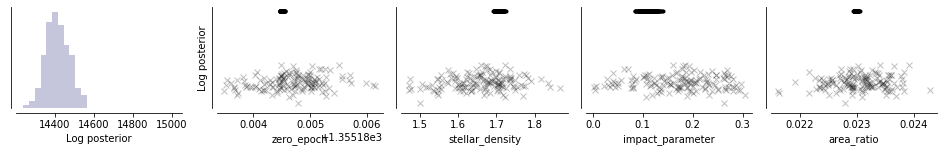

In [10]:
lpf.optimize_global(750, npop=npop)

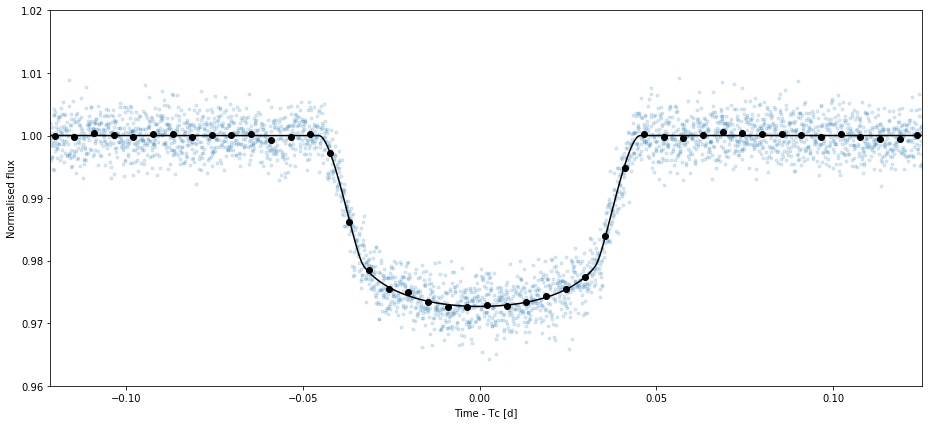

In [11]:
lpf.plot_folded_transit(ylim=(0.96, 1.02))

## MCMC

### Sample the posterior
We continue with an MCMC run, using the global optimisation population as the MCMC starting population. The MCMC sampling consists of a set of wamp-up runs where each run is started from the parameter vector population of the previous run's last iteration, and the chains from the previous run are discarded.

In [48]:
lpf.sample_mcmc(2500, thin=25, repeats=3)

## Analysis
### Plot the posterior model

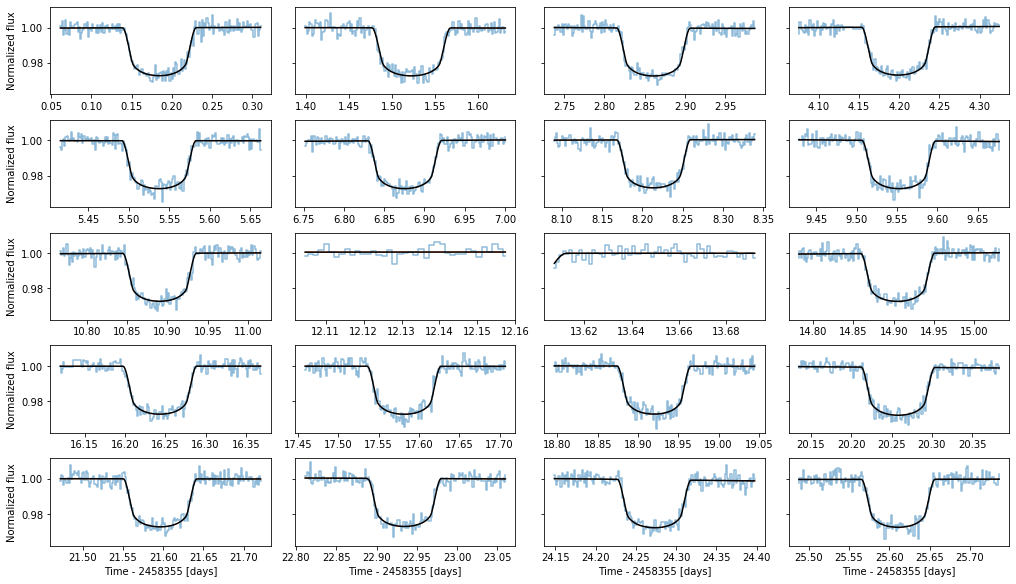

In [41]:
fig = lpf.plot_individual_transits(ncols=4)

### Plot the posterior transit centre

In [46]:
df = lpf.posterior_samples(thin=5)

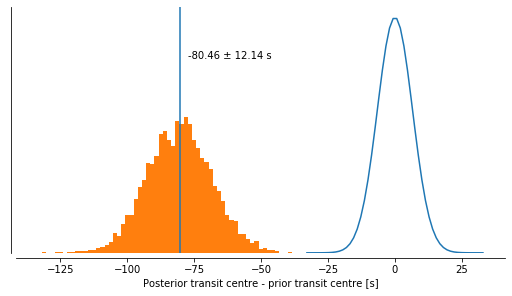

In [47]:
fig, ax = subplots(figsize=(7,4), constrained_layout=True)
d_to_s = 24*60*60
tc_diff = d_to_s*(df.tc-tc.n)
tc_diff_m = median(tc_diff)
x = linspace(- 5*tc.s, 5*tc.s)
ax.plot(d_to_s*x, norm(0, d_to_s*tc.s).pdf(a*x));
ax.hist(tc_diff, density=True, bins='auto')
ax.axvline(tc_diff_m)
ax.annotate(f'{tc_diff_m:.2f} ± {tc_diff.std():.2f} s', (tc_diff_m, 0.05), ((tc_diff_m+3, 0.05)))
setp(ax, xlabel='Posterior transit centre - prior transit centre [s]', yticks=[])
sb.despine(fig, offset=5)

### The default corner plot

Everyone likes corner plots, so let's do one for the main parameters.

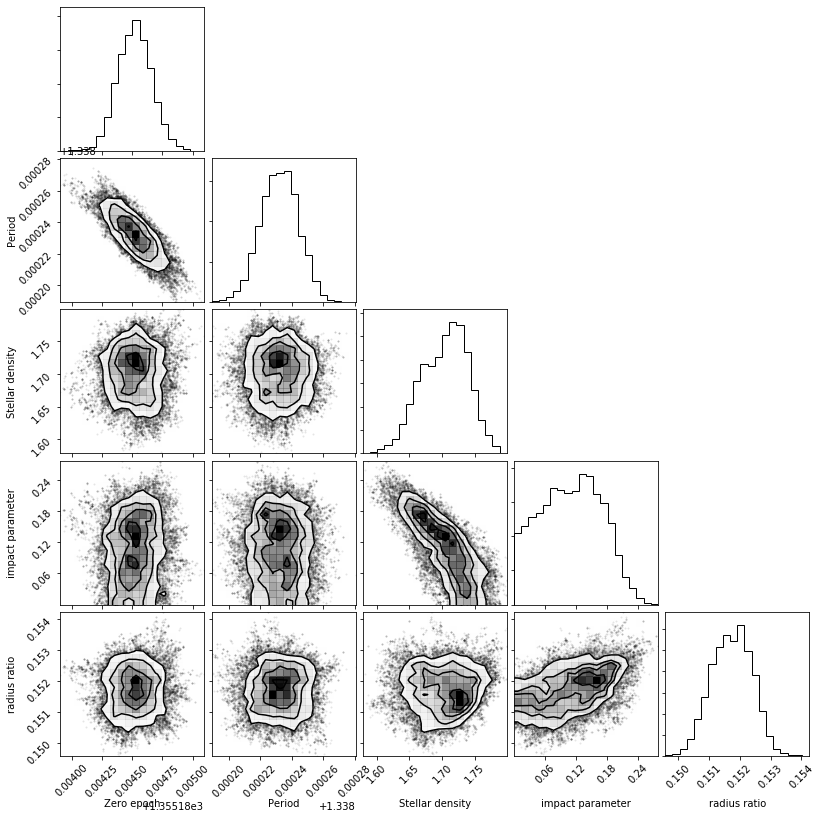

In [45]:
lpf.plot_basic_posteriors()

----
<center> © 2019 Hannu Parviainen </center>